In [1]:
#read data
from typing import List, Optional, Tuple
from typing import List, Optional, Tuple
from collections import namedtuple
import logging
import zipfile
import math
import sys
import tempfile
from typing import List, Optional, Tuple
from pathlib import Path 

from scipy import ndimage
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
NEIGHBOUR_PIXELS_MAX_DISTANCE_IN_METER = 0.05
def read_data(raw_data):
    with open(raw_data, 'rb') as file:
        line = str(file.readline())[2:-3]
        header = line.split("_")
        res = header[0].split("x")
        width = int(res[0])
        height = int(res[1])
        depthScale = float(header[1])
        maxConfidence = float(header[2])
        data = file.read()
        file.close()
    return data, width, height, depthScale

In [3]:
EXTRACTED_DEPTH_FILE_NAME = 'data'
IDENTITY_MATRIX_4D = [1., 0., 0., 0.,
                      0., 1., 0., 0.,
                      0., 0., 1., 0.,
                      0., 0., 0., 1.]

In [4]:
def matrix_calculate(position: List[float], rotation: List[float]) -> List[float]:
    """Calculate a matrix image->world from device position and rotation"""

    output = IDENTITY_MATRIX_4D

    sqw = rotation[3] * rotation[3]
    sqx = rotation[0] * rotation[0]
    sqy = rotation[1] * rotation[1]
    sqz = rotation[2] * rotation[2]

    invs = 1 / (sqx + sqy + sqz + sqw)
    output[0] = (sqx - sqy - sqz + sqw) * invs
    output[5] = (-sqx + sqy - sqz + sqw) * invs
    output[10] = (-sqx - sqy + sqz + sqw) * invs

    tmp1 = rotation[0] * rotation[1]
    tmp2 = rotation[2] * rotation[3]
    output[1] = 2.0 * (tmp1 + tmp2) * invs
    output[4] = 2.0 * (tmp1 - tmp2) * invs

    tmp1 = rotation[0] * rotation[2]
    tmp2 = rotation[1] * rotation[3]
    output[2] = 2.0 * (tmp1 - tmp2) * invs
    output[8] = 2.0 * (tmp1 + tmp2) * invs

    tmp1 = rotation[1] * rotation[2]
    tmp2 = rotation[0] * rotation[3]
    output[6] = 2.0 * (tmp1 + tmp2) * invs
    output[9] = 2.0 * (tmp1 - tmp2) * invs

    output[12] = -position[0]
    output[13] = -position[1]
    output[14] = -position[2]
    return output

In [5]:
def extract_depthmap(depthmap_fpath: str, dest_dir: str) -> Path:
    """Extract depthmap from given file"""
    with zipfile.ZipFile(Path(depthmap_fpath), 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    return Path(dest_dir) / EXTRACTED_DEPTH_FILE_NAME

In [6]:
def parse_calibration(filepath: str) -> List[List[float]]:
    """Parse calibration file
    filepath: The content of a calibration file looks like this:
        Color camera intrinsic:
        0.6786797 0.90489584 0.49585155 0.5035042
        Depth camera intrinsic:
        0.6786797 0.90489584 0.49585155 0.5035042
    """
    with open(filepath, 'r') as f:
        calibration = []
        for _ in range(2):
            f.readline().strip()
            line_with_numbers = f.readline()
            intrinsic = parse_numbers(line_with_numbers)
            calibration.append(intrinsic)
    return calibration

def parse_numbers(line: str) -> List[float]:
    """Parse line of numbers
    Args:
        line: Example: "0.6786797 0.90489584 0.49585155 0.5035042"
    Return:
        numbers: [0.6786797, 0.90489584, 0.49585155, 0.5035042]
    """
    return [float(value) for value in line.split(' ')]

In [7]:
def parse_header(header_line: str) -> Tuple:
        header_parts = header_line.split('_')
        res = header_parts[0].split('x')
        width = int(res[0])
        height = int(res[1])
        depth_scale = float(header_parts[1])
        max_confidence = float(header_parts[2])
        if len(header_parts) >= 10:
            position = (float(header_parts[7]), float(header_parts[8]), float(header_parts[9]))
            rotation = (float(header_parts[3]), float(header_parts[4]),
                        float(header_parts[5]), float(header_parts[6]))
            if position == (0., 0., 0.):
                print(f"device_pose looks wrong: position='{position}'")
                device_pose = None
            else:
                device_pose = matrix_calculate(position, rotation)
        else:
            device_pose = IDENTITY_MATRIX_4D
        return width, height, depth_scale, max_confidence, device_pose

In [8]:
def read_depthmap_data(depthmap_fpath):
        with tempfile.TemporaryDirectory() as tmpdirname:
            path = extract_depthmap(depthmap_fpath, tmpdirname)
            with open(path, 'rb') as f:
                header_line = f.readline().decode().strip()
                width, height, depth_scale, max_confidence, device_pose = parse_header(header_line)
                data = f.read()
                f.close()
        return width, height, data, depth_scale, max_confidence, device_pose, header_line 

In [9]:
def read_rgb_data(rgb_fpath, width, height):
        if rgb_fpath:
            pil_im = Image.open(rgb_fpath)
            pil_im = pil_im.rotate(-90, expand=True)
            rgb_height, rgb_width = pil_im.width, pil_im.height  # Weird switch
            assert rgb_width / width == rgb_height / height, f'{rgb_width} / {width} != {rgb_height} / {height}'
            pil_im = pil_im.resize((height, width), Image.ANTIALIAS)
            rgb_array = np.asarray(pil_im)
        else:
            rgb_array = None
        return rgb_array

In [10]:
def parse_depth_data(data,width,height,depth_scale) -> np.ndarray:
        output = np.zeros((width, height))
        for x in range(width):
            for y in range(height):
                output[x, y] = parse_depth(data, x, y,width,height,depth_scale)
        return output

def parse_depth(data: bytes, tx: int, ty: int,width,height,depth_scale) -> float:
    """Get depth of the point in meters"""
    if tx < 1 or ty < 1 or tx >= width or ty >= height:
        return 0.
    index = height - int(ty) - 1
    depth = data[(index * width + int(tx)) * 3 + 0] << 8
    depth += data[(index * width + int(tx)) * 3 + 1]
    depth *= depth_scale
    return depth

## Load and display depthmap and RGB files 

In [11]:
from os import walk

directory = [] 
path = 'C:/Users/vikas/Documents/assignments/mixed_scans/scans'

# path, directory, filenames = walk(path) 

for (_, dirnames, filenames) in walk('C:/Users/vikas/Documents/assignments/mixed_scans/scans'):
    directory.extend(dirnames)  
    break

# walk(path)

In [12]:
calibration_file = [] 
depthmap_file = [] 
rgb_file = [] 

for dir in directory:
    calibration_file.append(path + '/' + dir + '/calibration/0') 
    depthmap_file.append(path + '/' + dir + '/depth/1') 
    rgb_file.append(path + '/' + dir + '/rgb/1') 

In [13]:
# width, height, data, depth_scale, max_confidence, device_pose, header_line=read_depthmap_data(depthmap_file[0])

In [14]:
# print(type(data))
# img = Image.fromarray(data) 
# img.save("./image"+str(100)+".png")   

In [15]:
# calibration_file = './mixed_scans/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/calibration/0'
# depthmap_file = './mixed_scans/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/depth/1'
# rgb_file = './mixed_scans/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/rgb/1'

In [16]:
def create_from_zip_absolute(depthmap_fpath: str,rgb_fpath: str,
                                 calibration_fpath: str) -> 'Depthmap':
        width, height, data, depth_scale, max_confidence, device_pose, header_line = (read_depthmap_data(depthmap_fpath))
        depthmap =  parse_depth_data(data,width,height,depth_scale) 
        rgb_array = read_rgb_data(rgb_fpath, width, height)
        intrinsics = parse_calibration(calibration_fpath) 
        return (intrinsics, width, height, depthmap,depth_scale, max_confidence, device_pose, rgb_fpath, rgb_array, header_line)

C:\Users\vikas\AppData\Local\Temp\ipykernel_22120\4267084354.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_im = pil_im.resize((height, width), Image.ANTIALIAS)


(240, 180, 3)
(240, 180, 3)
(240, 180, 3)
(240, 180, 3)
(240, 180, 3)
(240, 180, 3)
device_pose looks wrong: position='(0.0, -0.0, -0.0)'
(240, 180, 3)
(240, 180, 3)
(240, 180, 3)
device_pose looks wrong: position='(0.0, -0.0, -0.0)'
(240, 180, 3)
(240, 180, 3)
(240, 180, 3)
device_pose looks wrong: position='(0.0, -0.0, -0.0)'
(240, 180, 3)
(240, 180, 3)


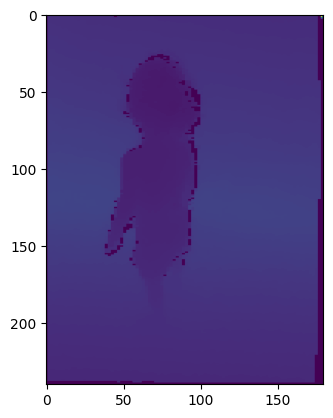

In [17]:
import numpy as np
from PIL import Image

counter = 0
for (df, rgb_f, cal_file) in zip(depthmap_file, rgb_file, calibration_file):
    data  = create_from_zip_absolute(df, rgb_f,cal_file) 
    
    plt.imshow(data[8])  

    print(data[8].shape) 


    img = Image.fromarray(data[8]) 
    img.save("./test_img_1/image"+str(counter)+".png")  
    
    img = Image.fromarray(data[3])  
    
    img = img.convert("L")

    # if img.mode != 'RGB':
    #     img = img.convert('RGB')
    plt.imshow(data[3]) 
    plt.savefig('./original_depth/depth'+str(counter)+'.png')
        
    # img.save("./image_depth"+str(counter)+".jpg")  
    counter += 1 